In [40]:
import pandas as pd
import numpy as np 
from tqdm.auto import tqdm
import joblib
import itertools

# 시각화
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.font_manager as fm

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GroupKFold, KFold, StratifiedKFold, TimeSeriesSplit

# 모델링
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn import tree

import eli5
from eli5.sklearn import PermutationImportance
import wandb

import warnings
warnings.filterwarnings('ignore')

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

In [2]:
all_path = '/data/ephemeral/home/aistages_ml/upstage-ml-regression-07/house_price_pred/data/interim/0122_total_data.csv'
df_all = pd.read_csv(all_path)
display(df_all)

,index,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,...,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,1000333,계단식,개별난방,75.73,1,3,1997,126.827102,37.540240,우림,...,3,0.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
1,1000334,혼합식,개별난방,58.17,22,6,1997,126.827102,37.540240,우림,...,3,52.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
2,981256,혼합식,개별난방,74.79,1,11,2005,126.824573,37.535397,빛여울,...,11,0.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
3,981257,혼합식,개별난방,74.81,5,3,2005,126.824573,37.535397,빛여울,...,11,4.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
4,981260,혼합식,개별난방,58.32,6,2,2003,126.824573,37.535397,신라이프,...,11,62.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.391500,50.592857,52.183484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,8366,계단식,개별난방,84.39,2,3,2003,126.956813,37.537144,삼성하이츠,...,6,774.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369
1128090,8452,계단식,개별난방,84.96,21,2,2002,126.960780,37.542132,효창아트빌2차,...,0,0.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369
1128091,8420,복도식,개별난방,63.44,12,4,1980,126.975789,37.551850,후암미주,...,6,163.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369
1128092,8433,타워형,개별난방,163.27,13,4,2004,126.977340,37.548844,브라운스톤남산,...,4,506.0,53.522857,57.264589,58.84635,62.704326,64.923778,69.795335,71.995999,75.087369


In [3]:
df_train = df_all[df_all['is_test'] == 0]
df_test = df_all[df_all['is_test'] == 1]

df_train = df_train.sort_values(by='index')
df_test = df_test.sort_values(by='index')

df_train = df_train.set_index('index').rename_axis(None)
df_test = df_test.set_index('index').rename_axis(None)

df_all = pd.concat([df_train, df_test])
display(df_all)

,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,...,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,계단식,개별난방,79.97,8,3,1987,127.057210,37.476763,개포6차우성,201712,...,4,-20.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
1,계단식,개별난방,79.97,22,4,1987,127.057210,37.476763,개포6차우성,201712,...,4,152.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
2,계단식,개별난방,54.98,28,5,1987,127.057210,37.476763,개포6차우성,201712,...,4,6.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
3,계단식,개별난방,79.97,3,4,1987,127.057210,37.476763,개포6차우성,201801,...,4,26.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
4,계단식,개별난방,79.97,8,2,1987,127.057210,37.476763,개포6차우성,201801,...,4,5.0,63.180018,70.288948,69.642773,71.197784,74.687709,81.053206,82.086797,85.061575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,복도식,개별난방,49.77,22,7,1996,127.093511,37.616533,신내6대주,202307,...,9,7.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
9268,복도식,개별난방,39.84,7,3,1996,127.093511,37.616533,신내6대주,202308,...,9,16.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
9269,혼합식,개별난방,59.76,17,4,1996,127.093511,37.616533,신내6대주,202308,...,9,10.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087
9270,복도식,개별난방,39.84,2,9,1996,127.093511,37.616533,신내6대주,202309,...,9,16.0,26.507618,27.821793,29.018909,30.316187,31.197193,32.823432,33.914443,35.143087


In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 61 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   복도유형                    1128094 non-null  object 
 1   난방방식                    1128094 non-null  object 
 2   전용면적                    1128094 non-null  float64
 3   계약일                     1128094 non-null  int64  
 4   층                       1128094 non-null  int64  
 5   건축년도                    1128094 non-null  int64  
 6   x                       1128094 non-null  float64
 7   y                       1128094 non-null  float64
 8   아파트명                    1128094 non-null  object 
 9   계약년월                    1128094 non-null  int64  
 10  도로명_x                   1128094 non-null  object 
 11  도로명주소                   1128094 non-null  object 
 12  mean_지상층수               1128094 non-null  float64
 13  sum_세대수                 1128094 non-null  float64
 14  sum_연

## Baseline 첫 번째 결과를 이용한 Feature Selection

In [5]:
drop_cols = ['도로명_x', '도로명주소', '총인구수', 'bus_count_500', 'bus_count_1500', 'bus_count_2000', '동', '시군구', '최저층', 'k-전체세대수', '난방방식', '주차대수', '소비자전세물가지수', '2017_ratio', '2018_ratio', '2019_ratio', '2020_ratio', '2021_ratio', '2022_ratio', '2023_ratio', '복도유형', 'is_station_area', '연GDP', '빌딩간격', '건축년도', 'mean_높이', '기준금리']
df_all = df_all.drop(columns=drop_cols)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 34 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   전용면적                    1128094 non-null  float64
 1   계약일                     1128094 non-null  int64  
 2   층                       1128094 non-null  int64  
 3   x                       1128094 non-null  float64
 4   y                       1128094 non-null  float64
 5   아파트명                    1128094 non-null  object 
 6   계약년월                    1128094 non-null  int64  
 7   mean_지상층수               1128094 non-null  float64
 8   sum_세대수                 1128094 non-null  float64
 9   sum_연면적                 1128094 non-null  float64
 10  mean_연면적                1128094 non-null  float64
 11  sum_건축면적                1128094 non-null  float64
 12  mean_건축면적               1128094 non-null  float64
 13  부속건축물수                  1128094 non-null  float64
 14  targe

In [6]:
df_all.isnull().sum()

전용면적                           0
계약일                            0
층                              0
x                              0
y                              0
아파트명                           0
계약년월                           0
mean_지상층수                      0
sum_세대수                        0
sum_연면적                        0
mean_연면적                       0
sum_건축면적                       0
mean_건축면적                      0
부속건축물수                         0
target                      9272
bus_min_dist                   0
sub_min_dist                   0
한강거리                           0
소비자월세물가지수                      0
dist_to_nearest_school         0
bus_count_1000                 0
대장아파트_거리                       0
도로명                            0
전용면적_filtered                  0
is_test                        0
이전가격                           0
매매수급동향                    329091
도로명_split                      0
세대수당_주차대수                 876277
년도별_세대수당_평균_주차대수              17
건물나이      

In [8]:
# 매매수급동향 -> 2012년 이후 데이터(~2013)
df_all = df_all.loc[df_all['계약년월'] >= 201301]
display(df_all)

,전용면적,계약일,층,x,y,아파트명,계약년월,mean_지상층수,sum_세대수,sum_연면적,...,is_test,이전가격,매매수급동향,도로명_split,세대수당_주차대수,년도별_세대수당_평균_주차대수,건물나이,최고층,거래날차이,2016_ratio
0,79.97,8,3,127.057210,37.476763,개포6차우성,201712,5.00,270.0,21960.54,...,0,124000.0,104.1,언주로,NaN,0.863383,36,5,-20.0,63.180018
1,79.97,22,4,127.057210,37.476763,개포6차우성,201712,5.00,270.0,21960.54,...,0,124000.0,104.1,언주로,NaN,0.863383,36,5,152.0,63.180018
2,54.98,28,5,127.057210,37.476763,개포6차우성,201712,5.00,270.0,21960.54,...,0,91500.0,104.1,언주로,NaN,0.863383,36,5,6.0,63.180018
3,79.97,3,4,127.057210,37.476763,개포6차우성,201801,5.00,270.0,21960.54,...,0,123500.0,107.0,언주로,NaN,0.863383,36,5,26.0,63.180018
4,79.97,8,2,127.057210,37.476763,개포6차우성,201801,5.00,270.0,21960.54,...,0,130000.0,107.0,언주로,NaN,0.863383,36,5,5.0,63.180018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,49.77,22,7,127.093511,37.616533,신내6대주,202307,11.25,1609.0,127417.74,...,1,15600.0,87.3,신내로19길,1.181818,0.889888,27,12,7.0,26.507618
9268,39.84,7,3,127.093511,37.616533,신내6대주,202308,11.25,1609.0,127417.74,...,1,13500.0,89.5,신내로19길,1.181818,0.889888,27,12,16.0,26.507618
9269,59.76,17,4,127.093511,37.616533,신내6대주,202308,11.25,1609.0,127417.74,...,1,23500.0,89.5,신내로19길,1.181818,0.889888,27,12,10.0,26.507618
9270,39.84,2,9,127.093511,37.616533,신내6대주,202309,11.25,1609.0,127417.74,...,1,13500.0,89.7,신내로19길,1.181818,0.889888,27,12,16.0,26.507618


In [24]:
# 년도별_세대수당_평균_주차대수 -> sum_세대수를 통한 결측치 채우기
df_all.loc[df_all['년도별_세대수당_평균_주차대수'].isnull()==True, ['sum_세대수', '계약년월']]

,sum_세대수,계약년월
1081443,1041.739764,202012
1081444,1041.739764,202108
1081445,1041.739764,202008
1081446,1041.739764,201905
1081447,1041.739764,201511
1081450,1041.739764,201412
1081451,1041.739764,201507
1081455,1041.739764,201303
1081456,1041.739764,201305
1081457,1041.739764,201306


In [18]:
df_all.loc[df_all['년도별_세대수당_평균_주차대수'].notnull()]

,전용면적,계약일,층,x,y,아파트명,계약년월,mean_지상층수,sum_세대수,sum_연면적,...,is_test,이전가격,매매수급동향,도로명_split,세대수당_주차대수,년도별_세대수당_평균_주차대수,건물나이,최고층,거래날차이,2016_ratio
0,79.97,8,3,127.057210,37.476763,개포6차우성,201712,5.00,270.0,21960.54,...,0,124000.0,104.1,언주로,NaN,0.863383,36,5,-20.0,63.180018
1,79.97,22,4,127.057210,37.476763,개포6차우성,201712,5.00,270.0,21960.54,...,0,124000.0,104.1,언주로,NaN,0.863383,36,5,152.0,63.180018
2,54.98,28,5,127.057210,37.476763,개포6차우성,201712,5.00,270.0,21960.54,...,0,91500.0,104.1,언주로,NaN,0.863383,36,5,6.0,63.180018
3,79.97,3,4,127.057210,37.476763,개포6차우성,201801,5.00,270.0,21960.54,...,0,123500.0,107.0,언주로,NaN,0.863383,36,5,26.0,63.180018
4,79.97,8,2,127.057210,37.476763,개포6차우성,201801,5.00,270.0,21960.54,...,0,130000.0,107.0,언주로,NaN,0.863383,36,5,5.0,63.180018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,49.77,22,7,127.093511,37.616533,신내6대주,202307,11.25,1609.0,127417.74,...,1,15600.0,87.3,신내로19길,1.181818,0.889888,27,12,7.0,26.507618
9268,39.84,7,3,127.093511,37.616533,신내6대주,202308,11.25,1609.0,127417.74,...,1,13500.0,89.5,신내로19길,1.181818,0.889888,27,12,16.0,26.507618
9269,59.76,17,4,127.093511,37.616533,신내6대주,202308,11.25,1609.0,127417.74,...,1,23500.0,89.5,신내로19길,1.181818,0.889888,27,12,10.0,26.507618
9270,39.84,2,9,127.093511,37.616533,신내6대주,202309,11.25,1609.0,127417.74,...,1,13500.0,89.7,신내로19길,1.181818,0.889888,27,12,16.0,26.507618


In [26]:
df_all.loc[df_all['년도별_세대수당_평균_주차대수'].isnull()==True, '년도별_세대수당_평균_주차대수'] = 0.853052
df_all.isnull().sum()

전용면적                           0
계약일                            0
층                              0
x                              0
y                              0
아파트명                           0
계약년월                           0
mean_지상층수                      0
sum_세대수                        0
sum_연면적                        0
mean_연면적                       0
sum_건축면적                       0
mean_건축면적                      0
부속건축물수                         0
target                      9272
bus_min_dist                   0
sub_min_dist                   0
한강거리                           0
소비자월세물가지수                      0
dist_to_nearest_school         0
bus_count_1000                 0
대장아파트_거리                       0
도로명                            0
전용면적_filtered                  0
is_test                        0
이전가격                           0
매매수급동향                         0
도로명_split                      0
세대수당_주차대수                 618861
년도별_세대수당_평균_주차대수               0
건물나이      

In [27]:
# 세대수당_주차대수 --> 선형보간
df_all['세대수당_주차대수'] = df_all['세대수당_주차대수'].interpolate(method='linear', axis=0)
df_all.isnull().sum()

전용면적                         0
계약일                          0
층                            0
x                            0
y                            0
아파트명                         0
계약년월                         0
mean_지상층수                    0
sum_세대수                      0
sum_연면적                      0
mean_연면적                     0
sum_건축면적                     0
mean_건축면적                    0
부속건축물수                       0
target                    9272
bus_min_dist                 0
sub_min_dist                 0
한강거리                         0
소비자월세물가지수                    0
dist_to_nearest_school       0
bus_count_1000               0
대장아파트_거리                     0
도로명                          0
전용면적_filtered                0
is_test                      0
이전가격                         0
매매수급동향                       0
도로명_split                    0
세대수당_주차대수                   12
년도별_세대수당_평균_주차대수             0
건물나이                         0
최고층                          0
거래날차이   

In [28]:
print(f"Before drop rows : {df_all.shape}")
df_all = df_all.dropna(subset=['세대수당_주차대수'])
print(f"After drop rows : {df_all.shape}")

Before drop rows : (799003, 34)
After drop rows : (798991, 34)


In [29]:
numeric_cols = df_all.select_dtypes(np.number)
categorical_cols = df_all.select_dtypes('object')

display(numeric_cols)
display(categorical_cols)

,전용면적,계약일,층,x,y,계약년월,mean_지상층수,sum_세대수,sum_연면적,mean_연면적,...,전용면적_filtered,is_test,이전가격,매매수급동향,세대수당_주차대수,년도별_세대수당_평균_주차대수,건물나이,최고층,거래날차이,2016_ratio
26,79.97,4,3,127.057210,37.476763,202112,5.00,270.0,21960.54,2745.06750,...,7.0,0,28700.0,92.8,1.925551,0.863383,36,5,93.0,63.180018
27,79.97,12,4,127.057210,37.476763,202204,5.00,270.0,21960.54,2745.06750,...,7.0,0,215000.0,90.8,1.925551,0.863383,36,5,129.0,63.180018
28,79.97,21,2,127.057210,37.476763,202204,5.00,270.0,21960.54,2745.06750,...,7.0,0,220000.0,90.8,1.925551,0.863383,36,5,9.0,63.180018
29,79.97,27,2,127.057210,37.476763,202205,5.00,270.0,21960.54,2745.06750,...,7.0,0,220000.0,90.1,1.925551,0.863383,36,5,36.0,63.180018
30,54.98,4,1,127.057210,37.476763,202012,5.00,270.0,21960.54,2745.06750,...,5.0,0,57500.0,117.3,1.925551,0.863383,36,5,101.0,63.180018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,49.77,22,7,127.093511,37.616533,202307,11.25,1609.0,127417.74,7963.60875,...,4.0,1,15600.0,87.3,1.181818,0.889888,27,12,7.0,26.507618
9268,39.84,7,3,127.093511,37.616533,202308,11.25,1609.0,127417.74,7963.60875,...,3.0,1,13500.0,89.5,1.181818,0.889888,27,12,16.0,26.507618
9269,59.76,17,4,127.093511,37.616533,202308,11.25,1609.0,127417.74,7963.60875,...,5.0,1,23500.0,89.5,1.181818,0.889888,27,12,10.0,26.507618
9270,39.84,2,9,127.093511,37.616533,202309,11.25,1609.0,127417.74,7963.60875,...,3.0,1,13500.0,89.7,1.181818,0.889888,27,12,16.0,26.507618


,아파트명,도로명,도로명_split
26,개포6차우성,언주로 3,언주로
27,개포6차우성,언주로 3,언주로
28,개포6차우성,언주로 3,언주로
29,개포6차우성,언주로 3,언주로
30,개포6차우성,언주로 3,언주로
...,...,...,...
9267,신내6대주,신내로19길 42,신내로19길
9268,신내6대주,신내로19길 42,신내로19길
9269,신내6대주,신내로19길 42,신내로19길
9270,신내6대주,신내로19길 42,신내로19길


In [35]:
df_train = df_all[df_all['is_test'] == 0]
df_test = df_all[df_all['is_test'] == 1]

del df_all['is_test']
del df_train['is_test']
del df_test['is_test']

In [30]:
df_all = df_all.drop(columns=['도로명', '도로명_split'])
numeric_cols = df_all.select_dtypes(np.number)
categorical_cols = df_all.select_dtypes('object')

display(numeric_cols)
display(categorical_cols)

,전용면적,계약일,층,x,y,계약년월,mean_지상층수,sum_세대수,sum_연면적,mean_연면적,...,전용면적_filtered,is_test,이전가격,매매수급동향,세대수당_주차대수,년도별_세대수당_평균_주차대수,건물나이,최고층,거래날차이,2016_ratio
26,79.97,4,3,127.057210,37.476763,202112,5.00,270.0,21960.54,2745.06750,...,7.0,0,28700.0,92.8,1.925551,0.863383,36,5,93.0,63.180018
27,79.97,12,4,127.057210,37.476763,202204,5.00,270.0,21960.54,2745.06750,...,7.0,0,215000.0,90.8,1.925551,0.863383,36,5,129.0,63.180018
28,79.97,21,2,127.057210,37.476763,202204,5.00,270.0,21960.54,2745.06750,...,7.0,0,220000.0,90.8,1.925551,0.863383,36,5,9.0,63.180018
29,79.97,27,2,127.057210,37.476763,202205,5.00,270.0,21960.54,2745.06750,...,7.0,0,220000.0,90.1,1.925551,0.863383,36,5,36.0,63.180018
30,54.98,4,1,127.057210,37.476763,202012,5.00,270.0,21960.54,2745.06750,...,5.0,0,57500.0,117.3,1.925551,0.863383,36,5,101.0,63.180018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,49.77,22,7,127.093511,37.616533,202307,11.25,1609.0,127417.74,7963.60875,...,4.0,1,15600.0,87.3,1.181818,0.889888,27,12,7.0,26.507618
9268,39.84,7,3,127.093511,37.616533,202308,11.25,1609.0,127417.74,7963.60875,...,3.0,1,13500.0,89.5,1.181818,0.889888,27,12,16.0,26.507618
9269,59.76,17,4,127.093511,37.616533,202308,11.25,1609.0,127417.74,7963.60875,...,5.0,1,23500.0,89.5,1.181818,0.889888,27,12,10.0,26.507618
9270,39.84,2,9,127.093511,37.616533,202309,11.25,1609.0,127417.74,7963.60875,...,3.0,1,13500.0,89.7,1.181818,0.889888,27,12,16.0,26.507618


,아파트명
26,개포6차우성
27,개포6차우성
28,개포6차우성
29,개포6차우성
30,개포6차우성
...,...
9267,신내6대주
9268,신내6대주
9269,신내6대주
9270,신내6대주


In [36]:
# 아파트명에 대해 Label Encoding 진행
label_encoders = {}

for col in categorical_cols:
    lbl = LabelEncoder()

    lbl.fit(df_train[col].astype(str))
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl

    for label in np.unique(df_test[col]):
        if label not in lbl.classes_:
            lbl.classes_ = np.append(lbl.classes_, label)

    df_test[col] = lbl.transform(df_test[col].astype(str))

In [37]:
display(df_train)

,전용면적,계약일,층,x,y,아파트명,계약년월,mean_지상층수,sum_세대수,sum_연면적,...,대장아파트_거리,전용면적_filtered,이전가격,매매수급동향,세대수당_주차대수,년도별_세대수당_평균_주차대수,건물나이,최고층,거래날차이,2016_ratio
26,79.97,4,3,127.057210,37.476763,318,202112,5.0,270.0,21960.54,...,5.516266,7.0,28700.0,92.8,1.925551,0.863383,36,5,93.0,63.180018
27,79.97,12,4,127.057210,37.476763,318,202204,5.0,270.0,21960.54,...,5.516266,7.0,215000.0,90.8,1.925551,0.863383,36,5,129.0,63.180018
28,79.97,21,2,127.057210,37.476763,318,202204,5.0,270.0,21960.54,...,5.516266,7.0,220000.0,90.8,1.925551,0.863383,36,5,9.0,63.180018
29,79.97,27,2,127.057210,37.476763,318,202205,5.0,270.0,21960.54,...,5.516266,7.0,220000.0,90.1,1.925551,0.863383,36,5,36.0,63.180018
30,54.98,4,1,127.057210,37.476763,318,202012,5.0,270.0,21960.54,...,5.516266,5.0,57500.0,117.3,1.925551,0.863383,36,5,101.0,63.180018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118805,18.09,14,4,127.079129,37.593212,2459,201407,8.0,44.0,2576.99,...,1.240959,1.0,7500.0,87.7,1.015239,1.185422,10,8,0.0,26.507618
1118806,30.91,14,7,127.079129,37.593212,2459,201407,8.0,44.0,2576.99,...,1.240959,3.0,13000.0,87.7,1.017862,1.185422,10,8,143.0,26.507618
1118807,30.91,14,4,127.079129,37.593212,2459,201407,8.0,44.0,2576.99,...,1.240959,3.0,12500.0,87.7,1.020485,1.185422,10,8,0.0,26.507618
1118808,18.09,14,3,127.079129,37.593212,2459,201407,8.0,44.0,2576.99,...,1.240959,1.0,7500.0,87.7,1.023109,1.185422,10,8,0.0,26.507618


In [38]:
display(f"Train shape : {df_train.shape}")
display(f"Test shape : {df_test.shape}")

'Train shape : (789719, 31)'

'Test shape : (9272, 31)'

## 모델링

In [39]:
# seed 고정
import random
import os

seed = 42
def random_seed(seed_num):
    random.seed(seed_num)
    np.random.seed(seed_num)
    os.environ['PYTHONHASHSEED'] = str(seed_num)

random_seed(seed)

In [44]:
target_col = 'target'
input_cols = df_train.columns.tolist()
input_cols.remove(target_col)

X_train = df_train[input_cols]
Y_train = df_train[target_col]

X_test = df_test[input_cols]
Y_test = df_test[target_col]

display(f"Train data shape : {X_train.shape}")
display(f"Train target shape : {Y_train.shape}")

display(f"Test data shape : {X_test.shape}")
display(f"Test target shape : {Y_test.shape}")

'Train data shape : (789719, 30)'

'Train target shape : (789719,)'

'Test data shape : (9272, 30)'

'Test target shape : (9272,)'

In [47]:
# KFold split 진행
kf = KFold(n_splits=5, random_state=seed, shuffle=True)

In [48]:
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x7fc7dc1dfa00>

In [50]:
run = wandb.init(project='AIStages-ML', name='kfold_baseline_lgbm_feature_selection')

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [52]:
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in tqdm(enumerate(train_folds)):
    print(f"---------{fold_idx}번째 fold의 학습을 시작합니다.-----------")

    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train.iloc[train_idx]

    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train.iloc[valid_idx]

    gbm = lgb.LGBMRegressor(n_estimators=10000)
    gbm.fit(X_train_fold, Y_train_fold,
            eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=10),
                       lgb.log_evaluation(period=100, show_stdv=True)])
    

    run.log({'train_rmse' : gbm.evals_result_['training']['rmse'][-1], 
             'valid_rmse' : gbm.evals_result_['valid_1']['rmse'][-1]})
    
    # 각 fold별 모델 저장
    file_path = '../models/'
    model_name = f'kfold{fold_idx}_lgbm_basline_feature_selection.pkl'
    joblib.dump(gbm, file_path+model_name)
    print(f"-----------{fold_idx}번째 학습이 종료되었습니다. {model_name}에 저장되었습니다. ----------")
    fold_save_files.append(file_path+model_name)

0it [00:00, ?it/s]

---------0번째 fold의 학습을 시작합니다.-----------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5468
[LightGBM] [Info] Number of data points in the train set: 631775, number of used features: 30
[LightGBM] [Info] Start training from score 64054.519493
Training until validation scores don't improve for 10 rounds
[100]	training's rmse: 8278.94	training's l2: 6.85409e+07	valid_1's rmse: 8914.83	valid_1's l2: 7.94743e+07
[200]	training's rmse: 7314.63	training's l2: 5.35038e+07	valid_1's rmse: 8160.75	valid_1's l2: 6.65979e+07
[300]	training's rmse: 6793.77	training's l2: 4.61553e+07	valid_1's rmse: 7798.75	valid_1's l2: 6.08205e+07
[400]	training's rmse: 6434.75	training's l2: 4.1406e+07	valid_1's rmse: 7559.08	valid_1's l2: 5.71397e+07
[500]	training's rmse: 6160.11	training's l2: 3.79469e+0

In [54]:
run.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_rmse,█▇▁▂
valid_rmse,██▁▃
train_rmse,3826.38256
valid_rmse,6056.92066


In [55]:
top4_models = ['../models/kfold0_lgbm_basline_feature_selection.pkl', '../models/kfold1_lgbm_basline_feature_selection.pkl', '../models/kfold2_lgbm_basline_feature_selection.pkl', '../models/kfold3_lgbm_basline_feature_selection.pkl']
total_predicts = np.zeros(len(X_test))

for model in top4_models:
    gbm_trained = joblib.load(model)
    fold_predict = gbm_trained.predict(X_test)

    total_predicts += fold_predict

total_predicts /= len(top4_models)
print(total_predicts[:5])

[206515.52327204 361314.79667379 291737.79419416 264083.472909
 231114.31877378]


In [58]:
df_preds = pd.DataFrame(total_predicts.astype(int), columns=['target'])
df_preds.to_csv('../data/interim/kfold_lgbm_baseline_feature_selection_output.csv', index=False)

## Feture Selection

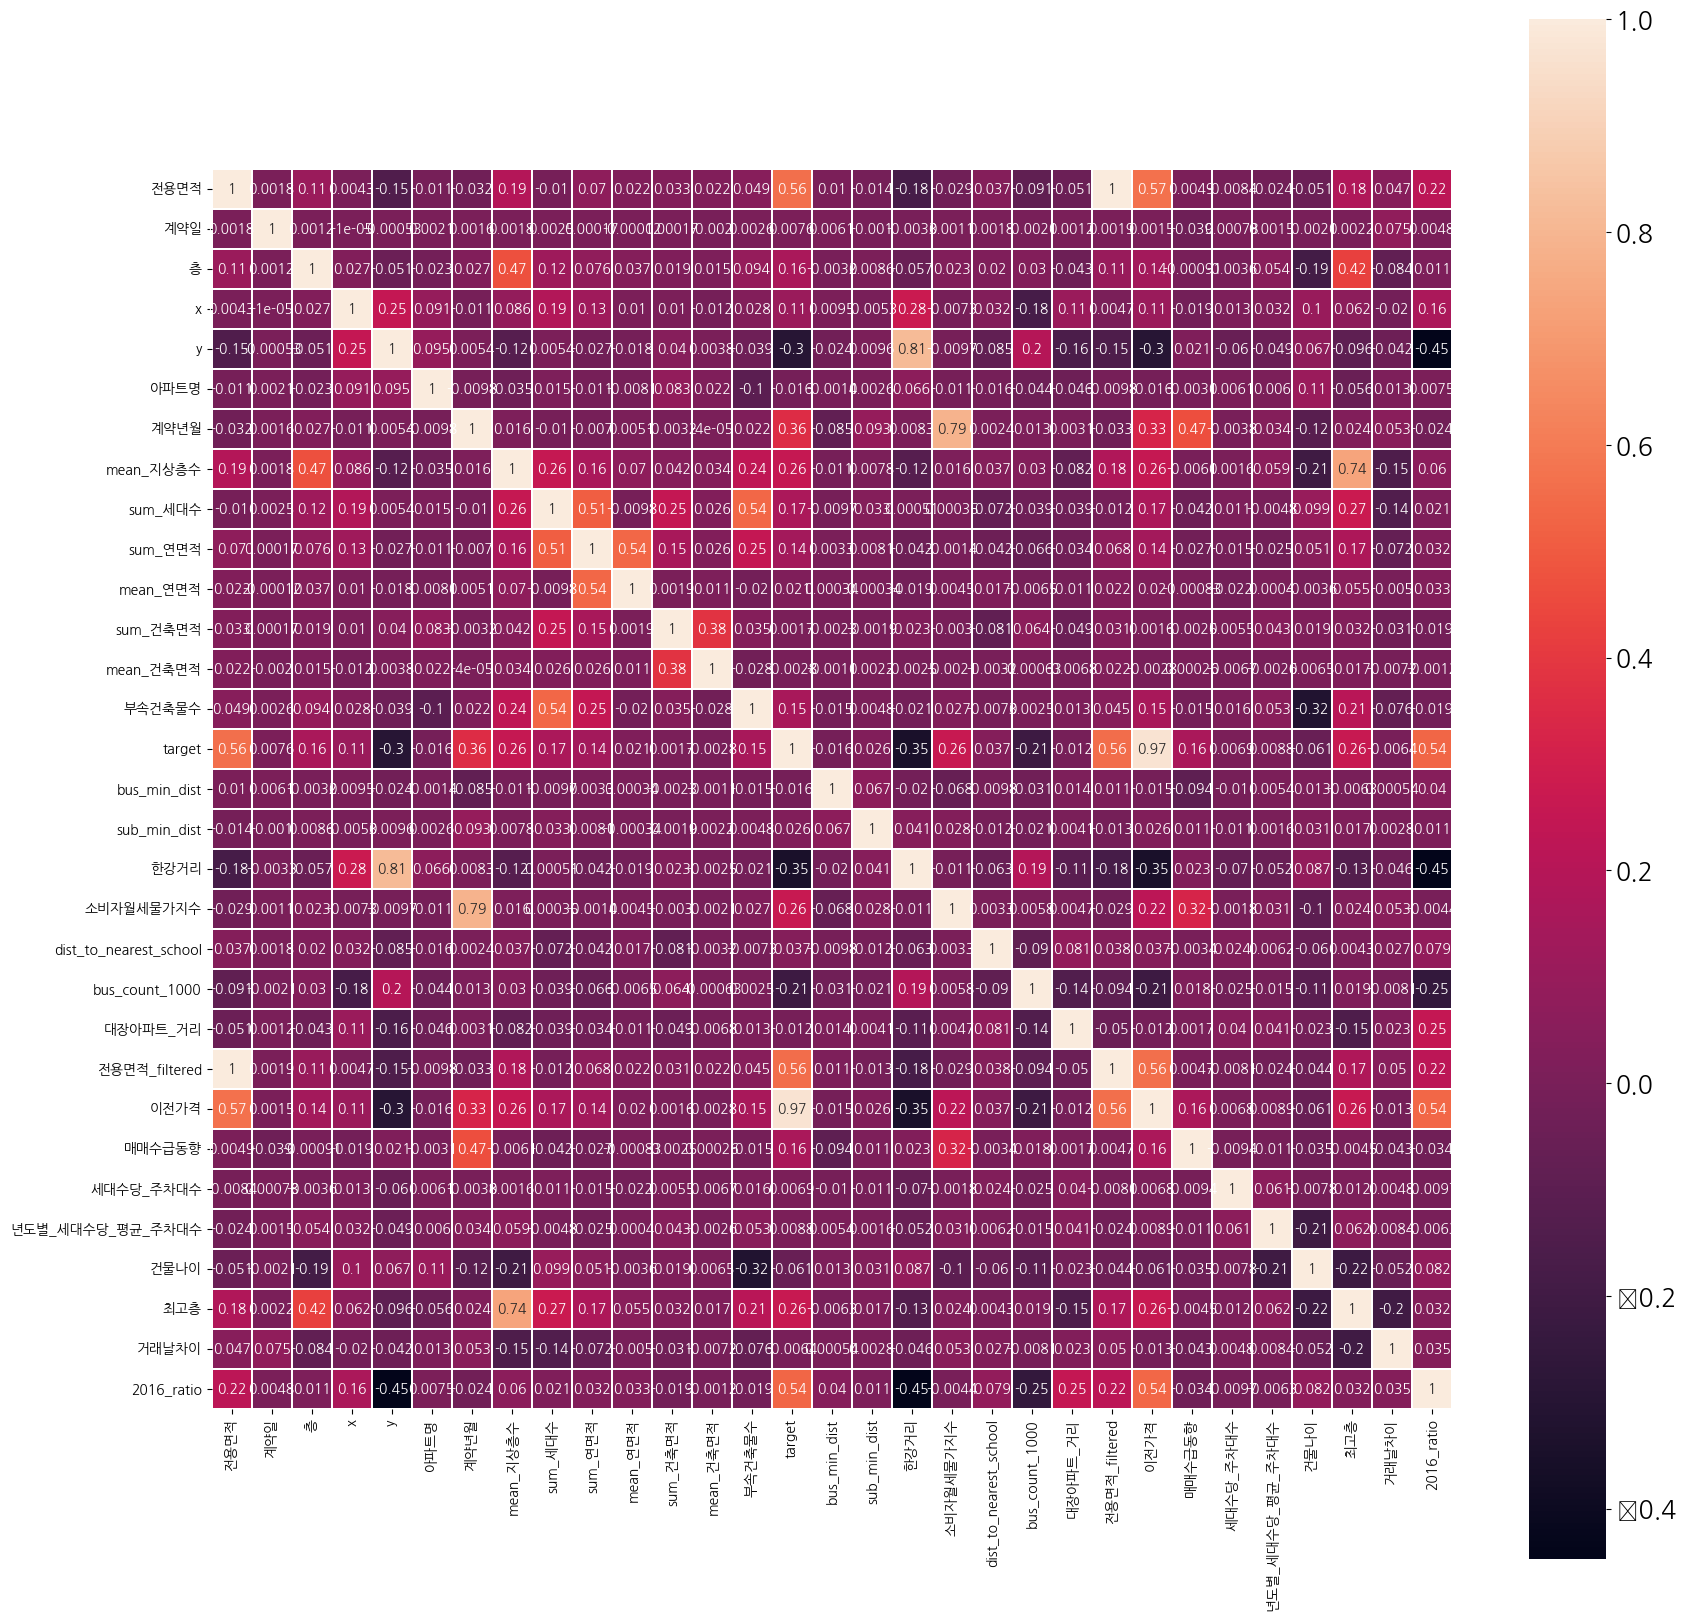

In [60]:
corr = df_train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, annot_kws={'size' : 10}, fmt='.2g', linewidths=0.2, square=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [61]:
# 모델 feature importances
model = joblib.load('../models/kfold2_lgbm_basline_feature_selection.pkl')
feat_imp = model.feature_importances_
feat_imp

array([ 8996,  3252,  4244,  5100,  3737,  3281, 10597,  2852,  3275,
        3040,  2992,  2380,  2517,  1387,  2217,  2131,  3664,   580,
        3028,  3064,  3761,  1162, 14200,  4063,  3411,  2102,  4723,
        2229,  5170,  3215], dtype=int32)

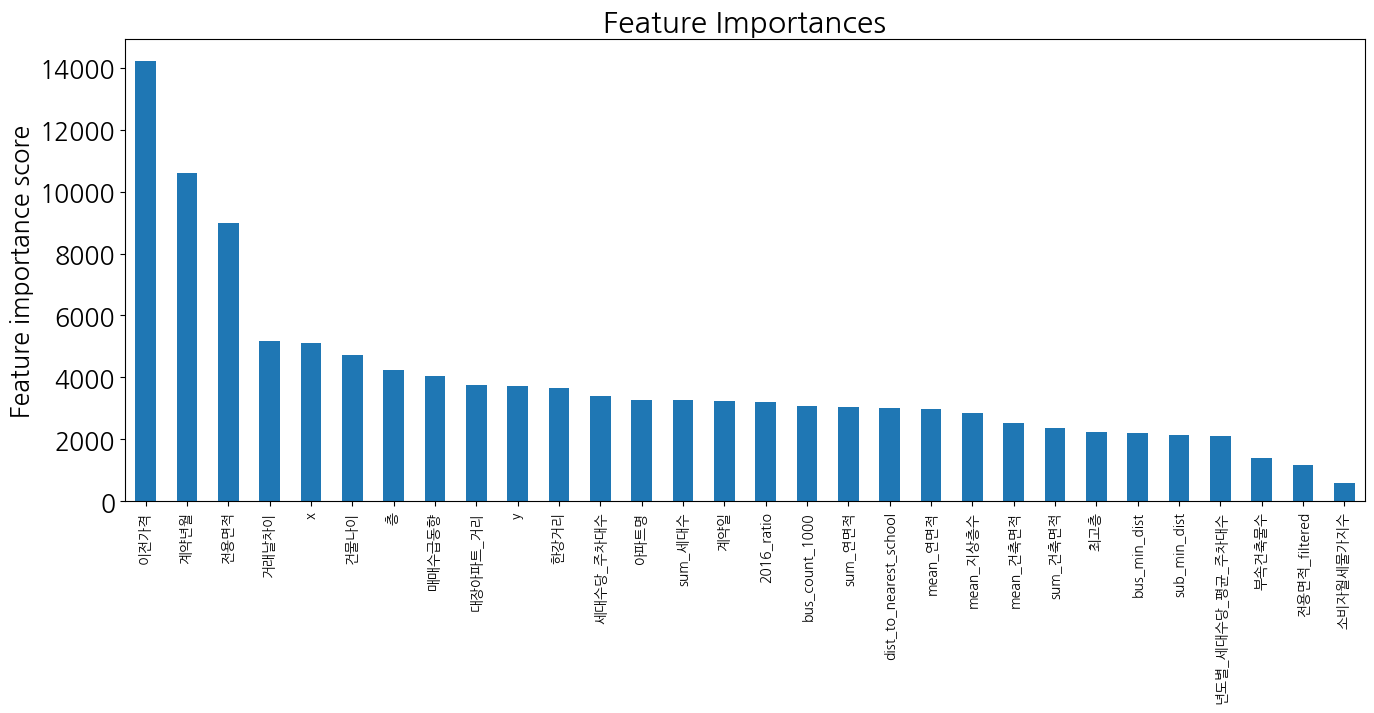

In [64]:
sorted_feat_imp = pd.Series(feat_imp, input_cols).sort_values(ascending=False)
plt.figure(figsize=(16, 6))
sorted_feat_imp.plot(kind='bar')
plt.title('Feature Importances')
plt.xticks(fontsize=10)
plt.ylabel('Feature importance score')
plt.show()

In [65]:
# Permutation Importance 기반

perm = PermutationImportance(model,
                             scoring='neg_root_mean_squared_error',
                             random_state=seed,
                             n_iter=5).fit(X_valid_fold, Y_valid_fold)

eli5.show_weights(perm, feature_names = X_valid_fold.columns.tolist())

Weight,Feature
27294.0727 ± 287.3055,계약년월
24776.4563 ± 156.8736,이전가격
18348.1024 ± 93.4605,전용면적
14877.8419 ± 78.5778,2016_ratio
6701.5874 ± 44.2708,한강거리
5249.6266 ± 38.8225,건물나이
5171.6894 ± 51.1473,x
2920.2393 ± 17.9182,sum_연면적
2697.9845 ± 34.8348,전용면적_filtered
2488.7864 ± 4.8093,y
